In [1]:
import os
import sys
basepath = '/' + os.path.join('Users', 'zach', 'Git', 'Masterarbeit', 'Project')
sys.path.append(basepath)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage, signal

# Enable full width output for numpy (https://stackoverflow.com/questions/43514106/python-terminal-output-width)
np.set_printoptions(suppress=True, linewidth=250, threshold=250)

from src.ml.training import load_model
from sklearn.pipeline import Pipeline
from src.d.transformators import TransformData, FindGradient, FindAngle, Rotate, CDS, HF, TwoLayers, Edge, UnsharpMask, Shift

In [3]:
# file_name = os.path.join(basepath, 'data', 'datasets', 'data_7x7_eqk_neg_sin_smr_shift1_n.feather')
file_name = os.path.join(basepath, 'data', 'datasets', 'data_7x7_eqk_neg_ell_nsm.feather')
data_orig = np.array(pd.read_feather(file_name))
data_orig = data_orig[:1000]
kappa = data_orig[:, 1]
concentration = data_orig[:, 1:]
concentration = np.reshape(concentration, (concentration.shape[0], 7, 7))

In [4]:
def make_stencil(factor, concentration):
    kernel_st = np.array(
        [[[0, 1, 0],
          [1, 2, 1],
          [0, 1, 0]]]
    )
    kernel_st = kernel_st/np.sum(kernel_st)

    stencils = concentration.copy()
    for i in range(int(np.floor(factor))):
        stencils = ndimage.convolve(stencils, kernel_st, mode='reflect')
    rest = factor - np.floor(factor) 
    stencils = rest*ndimage.convolve(stencils, kernel_st, mode='reflect') + (1-rest)*stencils
    return stencils

In [5]:
def sharpening(input_stencil, radius, amount):
    stencil = input_stencil.copy()
    check_kernel = np.array(
        [[[0, 1, 0],
         [1, 0, 1],
         [0, 1, 0]]]
    )
    
     # Initialize kernel for unsharp mask
    # '''
    kernel_mask = np.array([[
        [1, 2, 1],
        [2, 4, 2],
        [1, 2, 1]
    ]])
    '''
    kernel_mask = np.array(
        [[[0, 1, 0],
         [1, 4, 1],
         [0, 1, 0]]]
    )
    # '''
    kernel_mask = kernel_mask/np.sum(kernel_mask)
    # Initialize kernel for check mask
    kernel_check = np.array([[
        [0, 1, 0],
        [1, 0, 1],
        [0, 1, 0]
    ]])

    # Get mask: 1 where 0 < data < 1, else 0
    mask = np.where(((stencil > 0.0) & (stencil < 1.0)), 1, 0)
    # Convolve mask with check kernel to count neighbours where mask = 1
    mask_conv = ndimage.convolve(mask, kernel_check, mode='constant', cval=0.0)
    # Get indices where the stencil still has cells with more than 3 neighbours being between 0 and 1
    mask_index = np.argwhere(np.amax(mask_conv, axis=(1, 2)) > 3)[:, 0]
    # Get maximum neighbour count of every stencil
    mask_max = mask_conv.max()

    # '''
    # Calculate unsharp mask for unsharp masking
    unsharp_mask = ndimage.convolve(stencil, kernel_mask, mode='reflect')
    # '''
    '''
    # Calculate difference between data and unsharp mask for unsharp masking
    difference = data - unsharp_mask
    # '''
    # Initialize counter
    counter = 0
    # Repeat until every stencil is sharpened to a degree where no cell has more than 3 neighbours being between 0 and 1
    while mask_max > 3:
        '''
        # Calculate unsharp mask for unsharp masking every step
        unsharp_mask = ndimage.convolve(stencil, kernel_mask, mode='reflect')
        # '''
        # '''
        # Calculate difference between data and unsharp mask for unsharp masking
        difference = stencil - unsharp_mask
        # '''
        # Do unsharp masking in every stencil that still does not meet the requirement of containing only cells with 3 or less neighbours between 0 and 1
        stencil[mask_index, :, :] = np.round(np.clip((stencil[mask_index, :, :] + difference[mask_index, :, :]*amount), a_min=0, a_max=1), 6)

        # Get mask: 1 where 0 < data < 1, else 0
        mask = np.where(((stencil > 0.0) & (stencil < 1.0)), 1, 0)
        # Convolve mask with check kernel to count neighbours where mask = 1
        mask_conv = ndimage.convolve(mask, kernel_check, mode='constant', cval=0.0)
        # Get indices where the stencil still has cells with more than 3 neighbours being between 0 and 1
        mask_index = np.argwhere(np.amax(mask_conv, axis=(1, 2)) > 3)[:, 0]
        # Get maximum neighbour count of every stencil
        mask_max = mask_conv.max()

        # Count so it does not get stuck inside this loop
        counter = counter + 1
        if counter > 250:
            print('Interface reconstruction: max number of steps exceeded')
            break
    plt.bar(range(mask_conv.shape[0]), np.amax(mask_conv, axis=(1, 2)))
    plt.show()
    print(f'counter:\t{counter}')
       
    return stencil

(1000, 7, 7)


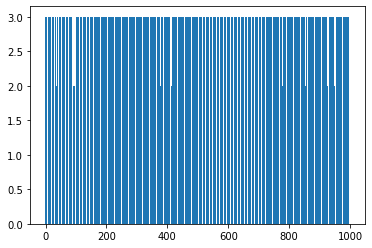

counter:	12


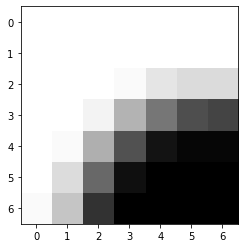

[[1.         1.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         1.         1.         1.         1.        ]
 [1.         1.         1.         0.97900391 0.89648437 0.85823568 0.8585612 ]
 [1.         1.         0.95654297 0.70166016 0.46354167 0.30485026 0.2672526 ]
 [1.         0.97753906 0.68391927 0.31754557 0.07698568 0.02490234 0.02522786]
 [1.         0.86051432 0.40820312 0.06217448 0.         0.         0.        ]
 [0.97884115 0.77050781 0.19580078 0.00065104 0.         0.         0.        ]]


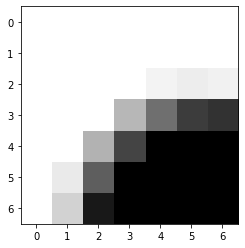

[[1.       1.       1.       1.       1.       1.       1.      ]
 [1.       1.       1.       1.       1.       1.       1.      ]
 [1.       1.       1.       1.       0.951927 0.928074 0.943554]
 [1.       1.       1.       0.717538 0.43571  0.236041 0.196283]
 [1.       1.       0.696602 0.266081 0.       0.       0.      ]
 [1.       0.916217 0.370945 0.       0.       0.       0.      ]
 [1.       0.821234 0.094796 0.       0.       0.       0.      ]]


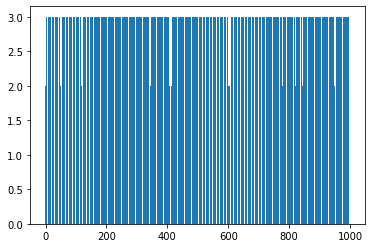

counter:	26


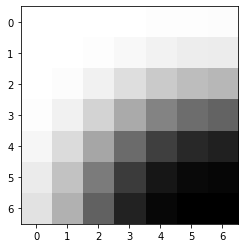

[[1.         1.         0.9995072  0.99650065 0.99190116 0.98878536 0.98809061]
 [1.         0.99900083 0.99058175 0.97073779 0.94595601 0.92890082 0.92241   ]
 [0.99898727 0.98671996 0.94486642 0.8708466  0.79283613 0.73952456 0.71766192]
 [0.98922541 0.94233383 0.8259963  0.66512873 0.51883726 0.42847584 0.39201072]
 [0.96111307 0.85768561 0.65153974 0.42042523 0.25120262 0.16383343 0.13402944]
 [0.9186861  0.75982515 0.48433431 0.23291242 0.09149697 0.03907757 0.02628505]
 [0.88493893 0.69270381 0.38474603 0.13888814 0.03120931 0.00543514 0.00275412]]


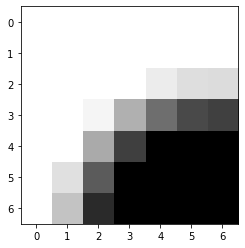

[[1.       1.       1.       1.       1.       1.       1.      ]
 [1.       1.       1.       1.       1.       1.       1.      ]
 [1.       1.       1.       1.       0.925454 0.868147 0.859752]
 [1.       1.       0.957927 0.689786 0.431537 0.291588 0.25051 ]
 [1.       1.       0.666357 0.249629 0.       0.       0.      ]
 [1.       0.877504 0.356989 0.       0.       0.       0.      ]
 [1.       0.762622 0.166843 0.       0.       0.       0.      ]]


In [6]:
stencil = make_stencil(1, concentration)
print(stencil.shape)
sharpened = sharpening(stencil, radius=1, amount=0.1)

index = 1
plt.imshow(stencil[index], cmap='gray')
plt.show()
print(stencil[index])

plt.imshow(sharpened[index], cmap='gray')
plt.show()
print(sharpened[index])

stencil = make_stencil(4, concentration)
sharpened = sharpening(stencil, radius=1, amount=0.1)

plt.imshow(stencil[index], cmap='gray')
plt.show()
print(stencil[index])

plt.imshow(sharpened[index], cmap='gray')
plt.show()
print(sharpened[index])

In [7]:
file_name = os.path.join(basepath, 'data', 'datasets', 'data_7x7_eqk_neg_ell_smr_shift1_int1.5.feather')
dataset = pd.read_feather(file_name)
dataset = dataset.iloc[:250, :]
orig_features = np.array(dataset)[:, 1:]
orig_features = np.reshape(orig_features, (orig_features.shape[0], 7, 7))
orig_labels = np.array(dataset)[: 1]
# Add steps to pipeline
pipeline_list = []
parameters = {'shift': 1, 'stencil_size': [7, 7], 'angle': False}
reshape = False
# Transform data to required format
pipeline_list.append(('transform', TransformData(parameters=parameters, reshape=reshape)))
# Find gradient in middle cell
pipeline_list.append(('findgradient', FindGradient(parameters=parameters)))
# Shift stencils
pipeline_list.append(('shift', Shift(parameters=parameters, shift=parameters['shift'])))
# Rotate stencils
# pipeline_list.append(('rotate', Rotate(parameters=parameters)))
# Interface reconstruction with unsharp mask
pipeline_list.append(('unsharp', UnsharpMask(parameters=parameters, amount=0.5)))

# Build pipeline
data_pipeline = Pipeline(pipeline_list)
# Execute pipeline
[labels, features, counter_vec] = data_pipeline.fit_transform(dataset)
sharpened_features = np.reshape(features, (features.shape[0], int(np.sqrt(features.shape[1])), int(np.sqrt(features.shape[1]))))

counter:	3


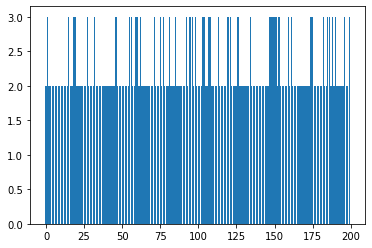

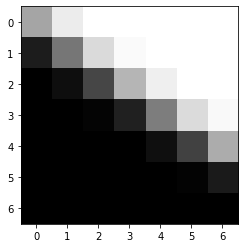

[[[0.64673394 0.92248491 0.99728652 1.         1.         1.         1.        ]
  [0.110799   0.46208239 0.85348077 0.97919665 1.         1.         1.        ]
  [0.00045225 0.05716399 0.2738651  0.70962524 0.93442422 0.99746742 1.        ]
  [0.         0.         0.01781852 0.13134502 0.49119401 0.85742378 0.97467418]
  [0.         0.         0.         0.00171854 0.05987747 0.26012116 0.67485352]
  [0.         0.         0.         0.         0.         0.01501459 0.10495655]
  [0.         0.         0.         0.         0.         0.         0.00027135]]]


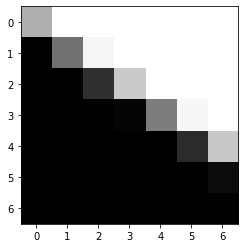

[[[0.687383 1.       1.       1.       1.       1.       1.      ]
  [0.       0.447142 0.963086 1.       1.       1.       1.      ]
  [0.       0.       0.189087 0.79083  1.       1.       1.      ]
  [0.       0.       0.       0.022762 0.48833  0.967768 1.      ]
  [0.       0.       0.       0.       0.       0.171577 0.78185 ]
  [0.       0.       0.       0.       0.       0.       0.046327]
  [0.       0.       0.       0.       0.       0.       0.      ]]]


In [14]:
# np.set_printoptions(formatter={'float': '{: 0.6f},'.format})
np.set_printoptions(suppress=True)


index = 5
# Bar plot
plt.bar(range(counter_vec[:200].shape[0]), counter_vec[:200])
plt.show()

indices = np.argwhere(counter_vec == 2)
plt.imshow(orig_features[indices[index]][0, :, :], cmap='gray')
plt.show()
print(orig_features[indices[index]])
plt.imshow(sharpened_features[indices[index]][0, :, :], cmap='gray')
plt.show()
print(sharpened_features[indices[index]])

(250, 50)
(100, 7, 7)


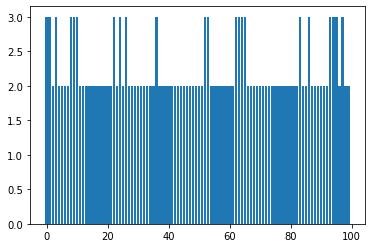

counter:	2


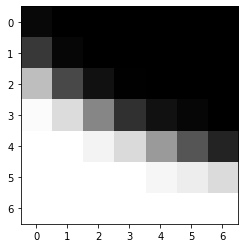

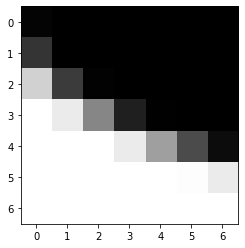

[[0.03202522 0.         0.         0.         0.         0.         0.        ]
 [0.22240629 0.02580856 0.         0.         0.         0.         0.        ]
 [0.74473381 0.28507841 0.06847746 0.00734696 0.         0.         0.        ]
 [0.98361062 0.85937813 0.52519682 0.19099171 0.0680065  0.02722144 0.00282575]
 [1.         0.99745682 0.95130283 0.85170963 0.60272092 0.33327853 0.13799424]
 [1.         1.         1.         0.99632652 0.96420711 0.92709553 0.85802048]
 [1.         1.         1.         1.         1.         1.         0.99632652]]
[[0.017374 0.       0.       0.       0.       0.       0.      ]
 [0.208565 0.       0.       0.       0.       0.       0.      ]
 [0.81892  0.231733 0.009425 0.       0.       0.       0.      ]
 [1.       0.920795 0.525837 0.121144 0.00494  0.       0.      ]
 [1.       1.       1.       0.919848 0.62324  0.29316  0.049761]
 [1.       1.       1.       1.       1.       0.992005 0.920201]
 [1.       1.       1.       1.       1.   

In [9]:
print(dataset.shape)
stencil = np.array(dataset)[indices[:100], 1:]
stencil = np.reshape(stencil, (stencil.shape[0], 7, 7))
print(stencil.shape)
sharp = sharpening(stencil, radius=1, amount=0.5)

index = 1
plt.imshow(stencil[index], cmap='gray')
plt.show()
plt.imshow(sharp[index], cmap='gray')
plt.show()
print(stencil[index])
print(sharp[index])